Source: https://www.kaggle.com/masumrumi/a-statistical-analysis-ml-workflow-of-titanic

# Titanic EDA & Machine Learning (replicated from Kaggle)

In [254]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [255]:
# Datasets
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# make columns lowercase
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

## Overview of Datasets

In [256]:
print('The shape of the train dataset is (row, column): ' + str(train.shape) + '\n')
print(train.info())
print()
print('The shape of the test dataset is (row, column): ' + str(test.shape) + '\n')
print(test.info())

The shape of the train dataset is (row, column): (891, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

The shape of the test dataset is (row, column): (418, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column   

We can see that there are missing (NA) values in Age, Cabin, and Embarked columns in both datasets

In [257]:
# finding missing values in dataset
def missing_percentage(df):
    """ This function takes a dataframe as input and returns two columns, total missing values and its percentage"""
    total = df.isnull().sum().sort_values(ascending = False) # total number of NA values
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df) * 100, 2) # percentage of NA values
    return pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])

missing_percentage(train)

,Total,Percent
cabin,687,77.10
age,177,19.87
embarked,2,0.22
fare,0,0.00
ticket,0,0.00
parch,0,0.00
sibsp,0,0.00
sex,0,0.00
name,0,0.00
pclass,0,0.00


In [258]:
missing_percentage(test)

,Total,Percent
cabin,327,78.23
age,86,20.57
fare,1,0.24
embarked,0,0.00
ticket,0,0.00
parch,0,0.00
sibsp,0,0.00
sex,0,0.00
name,0,0.00
pclass,0,0.00


### Filling in Missing Values

#### Embarked

In [259]:
def percent_value_counts(df, feature):
    """This function takes in a dataframe and a column and finds the percentage of the value_counts"""
    percent = pd.DataFrame(round(df.loc[:, feature].value_counts(dropna = False, normalize = True) * 100, 2))
    total = pd.DataFrame(df.loc[:, feature].value_counts(dropna = False))
    
    total.columns = ['Total']
    percent.columns = ['Percent']
    return pd.concat([total, percent], axis = 1)

percent_value_counts(train, 'embarked')

,Total,Percent
S,644,72.28
C,168,18.86
Q,77,8.64
NaN,2,0.22


We might replace NA values with S, the most occuring value. However, we can also try to dig in a little deeper in order to see if these NA values have commonality with other people

In [260]:
train[train['embarked'].isnull()]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Many things in common: sex, pclass, alone (sibsp, parch all 0), ticket, fare, and cabin. However, where they embarked may be correlated with their pclass and their price of the ticket. Thus, we can explore more on how fare might depend on class and the place of embarkation.

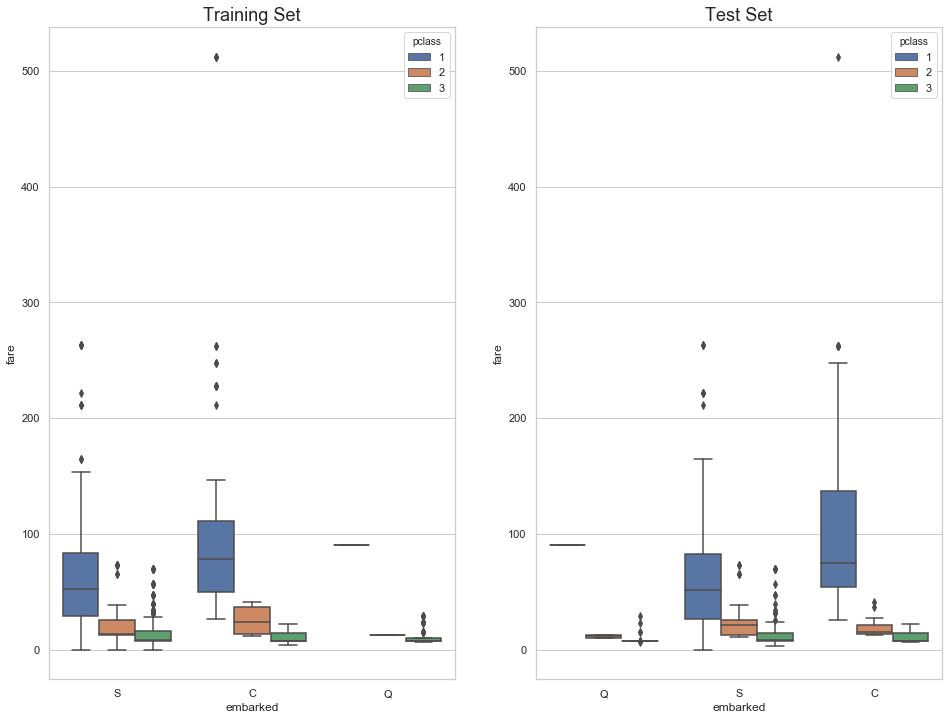

In [261]:
fig, ax = plt.subplots(figsize = (16, 12), ncols = 2)
ax1 = sns.boxplot(x = 'embarked', y = 'fare', hue = 'pclass', data = train, ax = ax[0]);
ax2 = sns.boxplot(x = 'embarked', y = 'fare', hue = 'pclass', data = test, ax = ax[1]);
ax1.set_title('Training Set', fontsize = 18)
ax2.set_title('Test Set', fontsize = 18)

fig.show()

For 1st class at fare of 80, Cherbourg's median seems to fit the best. Thus, instead of replacing them with mode value S, we should replace them with C

In [262]:
train.embarked.fillna('C', inplace = True)

#### Cabin

In [263]:
print('Train Cabin Missing: ' + str(train.cabin.isnull().sum()/len(train.cabin)))
print('Test Cabin Missing: ' + str(test.cabin.isnull().sum()/len(test.cabin)))

Train Cabin Missing: 0.7710437710437711
Test Cabin Missing: 0.7822966507177034


Cabin for both datasets have almost 80% of it missing. In this case we can:
1. get rid of the whole column
2. try to find similar characteristics and fill them in

For now, we will change them to N and combine train and test dataset

In [264]:
# take out survivors before joining the two
survivors = train.survived
print(survivors)
train.drop(['survived'], axis = 1, inplace = True)
all_data = pd.concat([train, test], ignore_index = False)
all_data.cabin.fillna('N', inplace = True)

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: survived, Length: 891, dtype: int64


In [265]:
all_data.cabin.value_counts()

N                  1014
C23 C25 C27           6
B57 B59 B63 B66       5
G6                    5
B96 B98               4
                   ... 
C70                   1
B52 B54 B56           1
C49                   1
C30                   1
C28                   1
Name: cabin, Length: 187, dtype: int64

Since all values begin with alphabets and values with multiple cabins all start with the same letter, extract the first letter from every value and assign as the value

In [266]:
all_data.cabin = [i[0] for i in all_data.cabin]

In [267]:
percent_value_counts(all_data, 'cabin')

,Total,Percent
N,1014,77.46
C,94,7.18
B,65,4.97
D,46,3.51
E,41,3.13
A,22,1.68
F,21,1.60
G,5,0.38
T,1,0.08


However, this only shows the frequency of each cabin letter, and we want to try to fit them a little better than just the frequency. So, finding the average fares for each letter:

In [268]:
all_data.groupby('cabin')['fare'].mean().sort_values()

cabin
G     14.205000
F     18.079367
N     19.132707
T     35.500000
A     41.244314
D     53.007339
E     54.564634
C    107.926598
B    122.383078
Name: fare, dtype: float64

From this we can guess that cabin might be correlated with fare price. Thus, let's assign cabin letters based on their fares compared to the middle point of average fares of each cabin letters

In [269]:
def cabin_estimator(i):
    """ grouping cabin feature by the first letter"""
    a = 0
    if i < 16:
        a = 'G'
    elif i >= 16 and i < 27:
        a = 'F'
    elif i >= 27 and i < 38:
        a = 'T'
    elif i >= 38 and i < 47:
        a = 'A'
    elif i >= 47 and i < 53:
        a = 'E'
    elif i >= 53 and i < 54: # maybe got switched up with E?
        a = 'D'
    elif i >= 54 and i < 116:
        a = 'C'
    else:
        a = 'B'
    return a

In [270]:
with_n = all_data[all_data.cabin == 'N']
without_n = all_data[all_data.cabin != 'N']

In [271]:
# apply cabin_estimator to convert all N
with_n['cabin'] = with_n.fare.apply(lambda x: cabin_estimator(x))

# join back the two
all_data = pd.concat([with_n, without_n], axis = 0)

# sort out passengerid to separate back train and test
all_data.sort_values(by = 'passengerid', inplace = True)

# separate back
train = all_data[:891]
test = all_data[891:]

# add back survived
train['survived'] = survivors

#### Fare

There is only one value missing in fare column, which is in test:

In [272]:
test[test.fare.isnull()]

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,B,S


We can fill in simply using the average, but we can try to classify as much as possible before taking the average.

In [273]:
test.fare.fillna(test[ (test.pclass == 3) &
                     (test.embarked == 'S') &
                     (test.sex == 'male')].fare.mean(), inplace = True)

#### Age

In [274]:
print('Train age missing value: ' + str((train.age.isnull().sum()/len(train)) * 100) + '%')
print('Test age missing value: ' + str((test.age.isnull().sum()/len(test)) * 100) + '%')

Train age missing value: 19.865319865319865%
Test age missing value: 20.574162679425836%


1/5 of the values in age column in both datasets are missing, but since age seems to be a crucial factor in determining survival, instead of simply replacing them with median, mean, or mode, we will use Random Forest Regressor to impute the missing values later

## Visualization and Correlation between Features (EDA)

Some Assumptions:
* Gender: female survived more
* Pclass: higher socio-economic status passenger survived more
* Age: younger passenger survived more
* Fare: passenger with higher fare survived more, but this is probably correlated to pclass

### Gender

Text(0.5, 0, 'Sex')

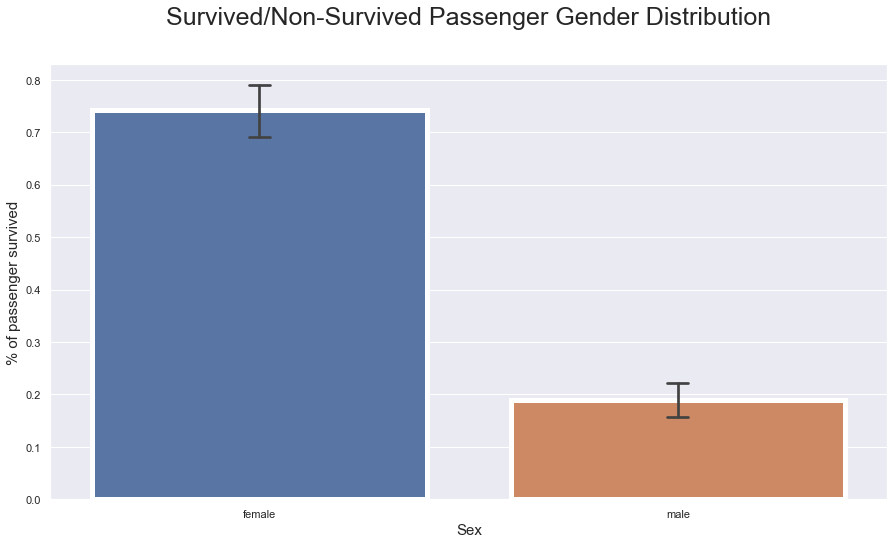

In [275]:
sns.set(style = 'darkgrid')
plt.subplots(figsize = (15, 8))
ax = sns.barplot(x = 'sex',
                y = 'survived',
                data = train,
                linewidth = 5,
                order = ['female', 'male'],
                capsize = 0.05)
plt.title('Survived/Non-Survived Passenger Gender Distribution', fontsize = 25, loc = 'center', pad = 40)
plt.ylabel('% of passenger survived', fontsize = 15)
plt.xlabel('Sex', fontsize = 15)


We can see that survival between the two genders are different by a lot

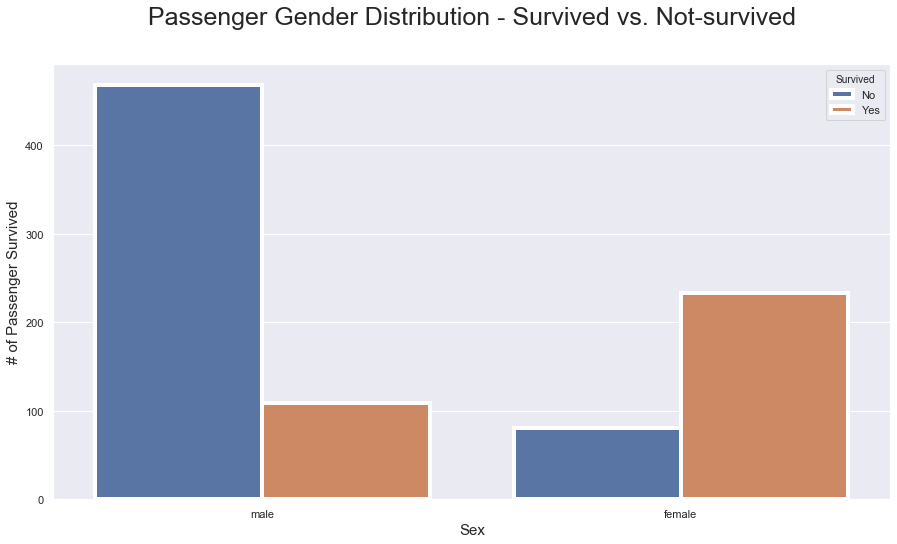

In [276]:
sns.set(style = 'darkgrid')
plt.subplots(figsize = (15, 8))
ax = sns.countplot(x = 'sex', 
                  hue = 'survived',
                  data = train,
                  linewidth = 4)

plt.title('Passenger Gender Distribution - Survived vs. Not-survived', fontsize = 25, pad = 40)
plt.xlabel('Sex', fontsize = 15)
plt.ylabel('# of Passenger Survived', fontsize = 15)

leg = ax.get_legend()
leg.set_title('Survived')
legs = leg.texts
legs[0].set_text('No')
legs[1].set_text('Yes')
plt.show()

Proves that a lot more females survived than male

### Class

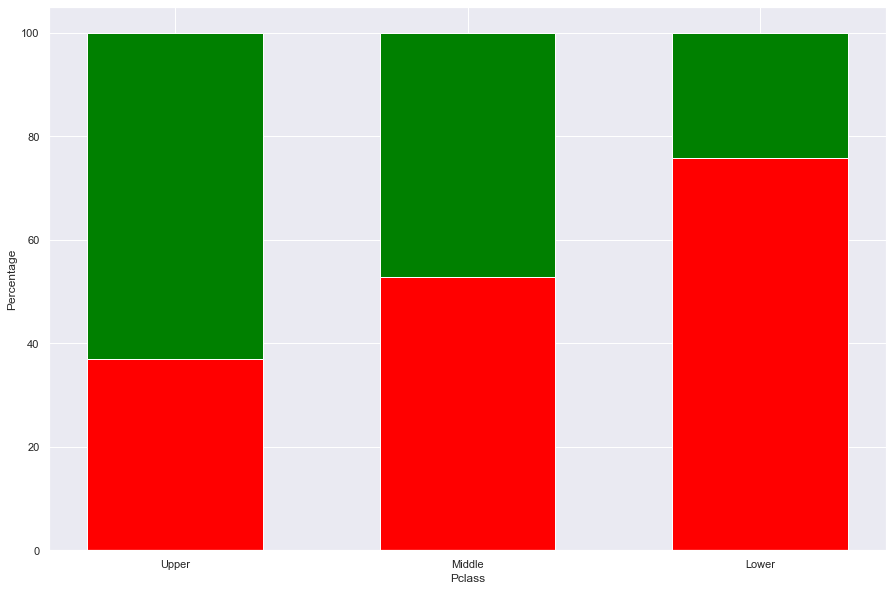

In [277]:
temp = train[['pclass', 'survived', 'passengerid']].groupby(['pclass', 'survived']).count().reset_index()
temp_df = pd.pivot_table(temp, values = 'passengerid', index = 'pclass', columns = 'survived')
names = ['No', 'Yes']
temp_df.columns = names
r = [0, 1, 2]
totals = [i + j for i, j in zip(temp_df['No'], temp_df['Yes'])]
No_s = [i / j * 100 for i, j in zip(temp_df['No'], totals)]
Yes_s = [i / j * 100 for i, j in zip(temp_df['Yes'], totals)]

# # Plotting
plt.subplots(figsize = (15, 10))
barWidth = 0.6
names = ('Upper', 'Middle', 'Lower')

# # Green bars
plt.bar(r, No_s, color = 'Red', edgecolor = 'white', width = barWidth)
# Orange bars
plt.bar(r, Yes_s, bottom = No_s, color = 'Green', edgecolor = 'white', width = barWidth)

# # Custom x axis
plt.xticks(r, names)
plt.xlabel('Pclass')
plt.ylabel('Percentage')

# # Show graphic
plt.show()

([<matplotlib.axis.XTick at 0x18135db5cc8>,
 <a list of 3 Text xticklabel objects>)

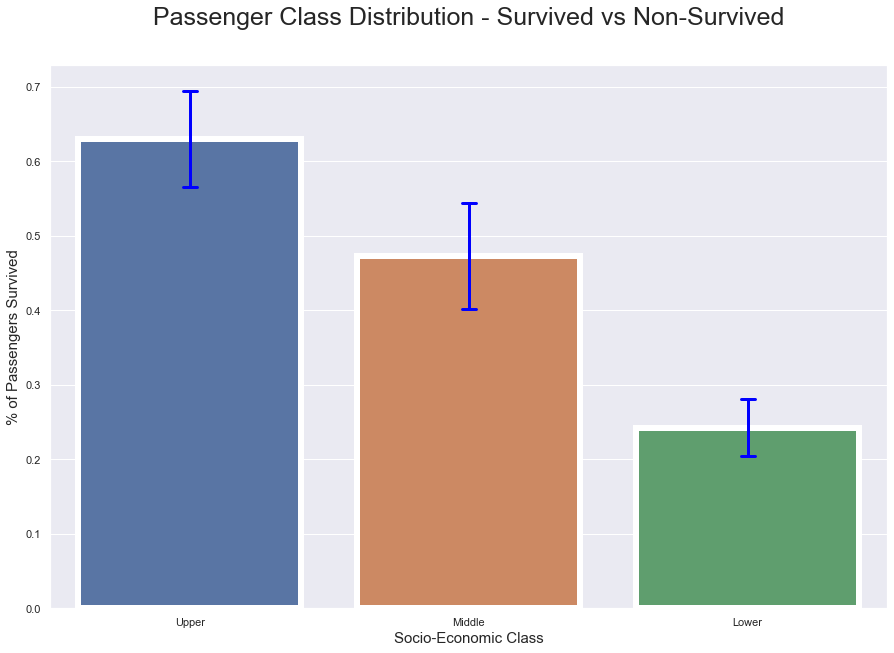

In [278]:
plt.subplots(figsize = (15, 10))
sns.barplot(x = 'pclass',
           y = 'survived',
           data = train,
           linewidth = 6,
           capsize = 0.05,
           errcolor = 'blue',
           errwidth = 3)

plt.title('Passenger Class Distribution - Survived vs Non-Survived', fontsize = 25, pad = 40)
plt.xlabel('Socio-Economic Class', fontsize = 15)
plt.ylabel('% of Passengers Survived', fontsize = 15)
names = ['Upper', 'Middle', 'Lower']
val = [0, 1, 2]
plt.xticks(val, names)

([<matplotlib.axis.XTick at 0x18135ab0688>,
 <a list of 3 Text xticklabel objects>)

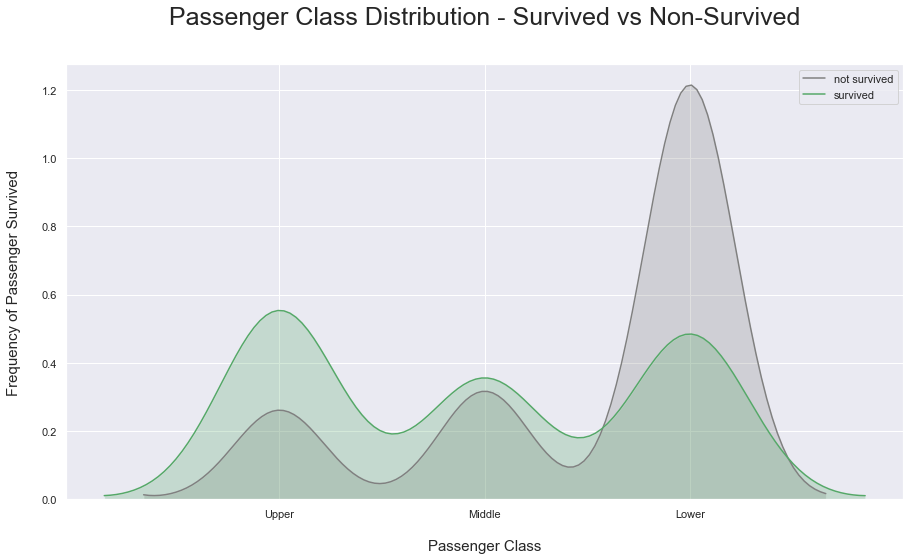

In [279]:
fig = plt.figure(figsize = (15, 8),)
ax = sns.kdeplot(train.pclass[train.survived == 0],
                color = 'gray',
                shade = True,
                label = 'not survived')
ax = sns.kdeplot(train.pclass[train.survived == 1],
                color = 'g',
                shade = True,
                label = 'survived')
plt.title('Passenger Class Distribution - Survived vs Non-Survived', fontsize = 25, pad = 40)
plt.ylabel('Frequency of Passenger Survived', fontsize = 15, labelpad = 20)
plt.xlabel('Passenger Class', fontsize = 15, labelpad = 20)

labels = ['Upper', 'Middle', 'Lower']
plt.xticks(sorted(train.pclass.unique()), labels)

All graphs show that passengers of higher socio-economic status survived a lot more in percentage

### Fare

Text(0.5, 0, 'Fare')

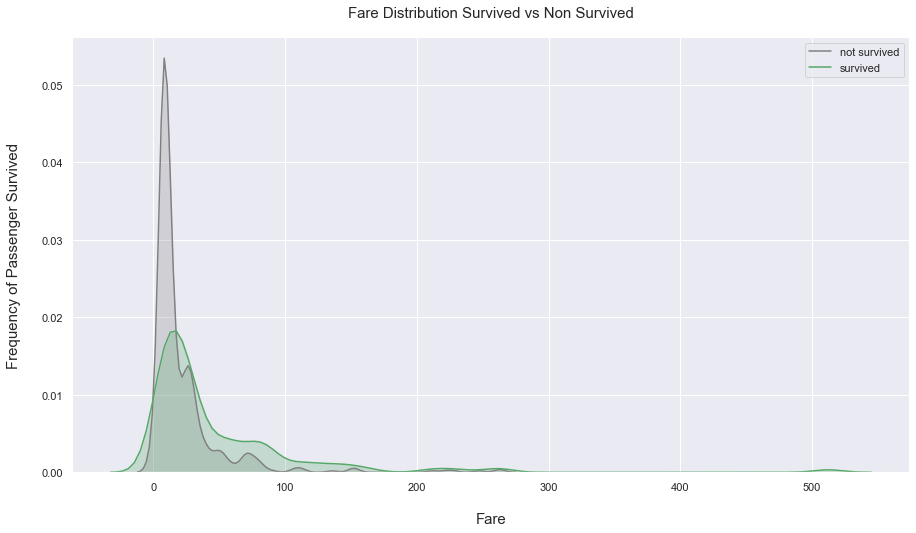

In [280]:
fig = plt.figure(figsize = (15, 8),)
ax = sns.kdeplot(train.loc[(train['survived'] == 0), 'fare'], color = 'gray', shade = True, label = 'not survived')
ax = sns.kdeplot(train.loc[(train['survived'] == 1), 'fare'], color = 'g', shade = True, label = 'survived')
plt.title('Fare Distribution Survived vs Non Survived', fontsize = 15, pad = 20)
plt.ylabel('Frequency of Passenger Survived', fontsize = 15, labelpad = 20)
plt.xlabel('Fare', fontsize = 15, labelpad = 20)

Two interesting points in this plot:
1. There is a huge spike under 100 dollars in people who did not survive
2. there is no gray area at all after around 280, but a little lump in around 500. They might be outliers or it might mean that people who paid over 300 all survived, so we can check:

In [281]:
train[train['fare'] > 280]

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived
258,259,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,B,C,1
679,680,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B,C,1
737,738,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B,C,1


These points seem to be an outlier, so we might have to deal with them later

### Age

Text(0, 0.5, 'Frequency')

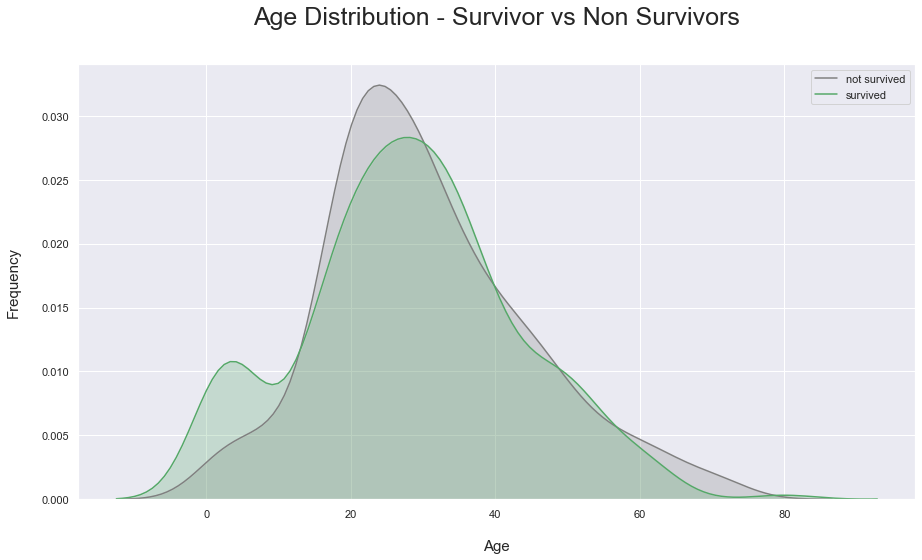

In [282]:
fig = plt.figure(figsize = (15, 8), )
ax = sns.kdeplot(train.loc[(train['survived'] == 0), 'age'], color = 'gray', shade = True, label = 'not survived')
ax = sns.kdeplot(train.loc[(train['survived'] == 1), 'age'], color = 'g', shade = True, label = 'survived')
plt.title('Age Distribution - Survivor vs Non Survivors', fontsize = 25, pad = 40)
plt.xlabel('Age', fontsize = 15, labelpad = 20)
plt.ylabel('Frequency', fontsize = 15, labelpad = 20)

We can see that the two areas are mostly similar except for the younger people of age lower than 12, which shows that young children were priority for survival

### Combined

#### Sex & Age

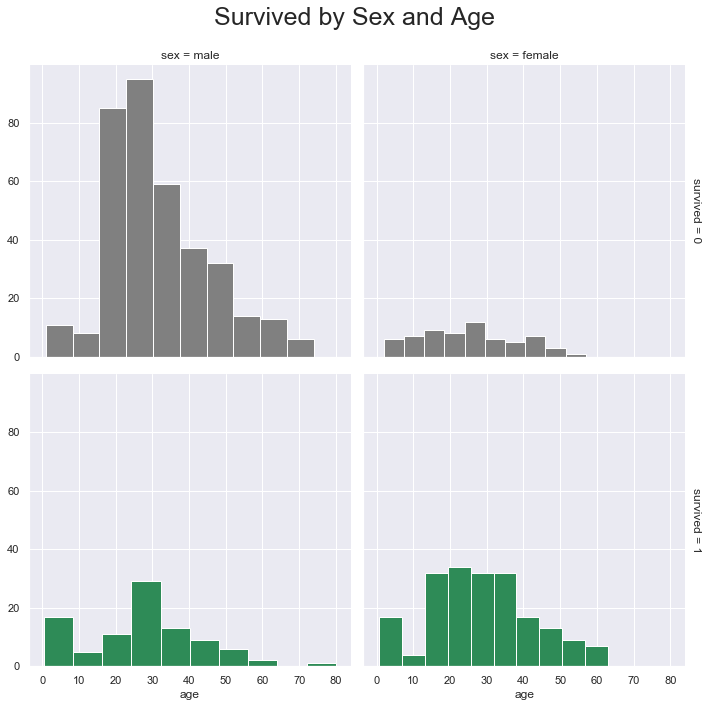

In [283]:
pal = {1: 'seagreen', 0: 'gray'}
g = sns.FacetGrid(train, size = 5, col = 'sex', row = 'survived', margin_titles = True, hue = 'survived', palette = pal)
g = g.map(plt.hist, 'age', edgecolor = 'white')
g.fig.suptitle('Survived by Sex and Age', size = 25)
plt.subplots_adjust(top = 0.9)

As we have found before, higher percentage of women survived compared to men, and there is a little spike in younger population

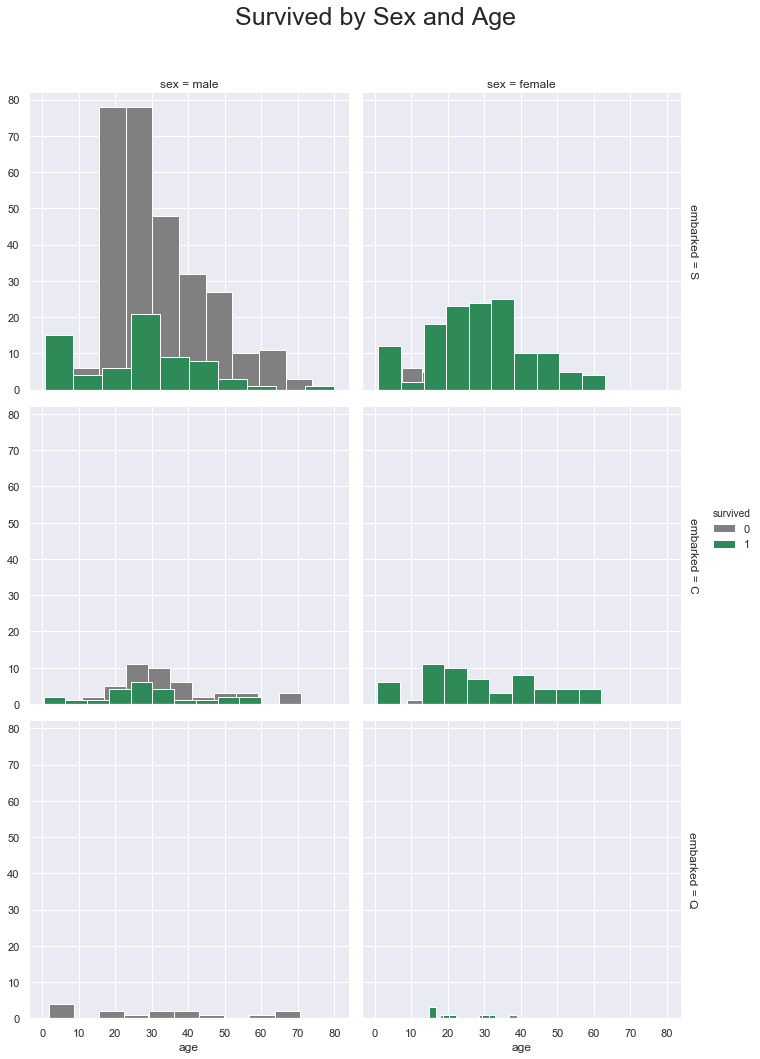

In [284]:
g = sns.FacetGrid(train, col = 'sex', row = 'embarked', size = 5, margin_titles = True, hue = 'survived', palette = pal)
g = g.map(plt.hist, 'age', edgecolor = 'white').add_legend()
g.fig.suptitle('Survived by Sex and Age', size = 25)
plt.subplots_adjust(top = 0.9)

In this graph we have divided survival amongst embarked places, and we can see that
1. Majority of passengers boarded at Southampton
2. Almost all males from Queenstown did not survive
3. Only a few women boarded at Queenstown, but most of them survived

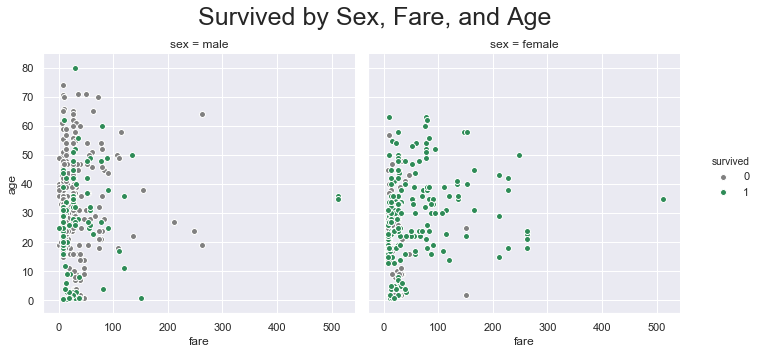

In [285]:
g = sns.FacetGrid(train, col = 'sex', hue = 'survived', size = 5, margin_titles = 'True', palette = pal, )
g.map(plt.scatter, 'fare', 'age', edgecolor = 'w').add_legend()
g.fig.suptitle('Survived by Sex, Fare, and Age', size = 25)
plt.subplots_adjust(top = 0.85)

We can clearly see the three outliers for both sexes, and should be removed later.
Also, we can see that most of the fares are under 100

In [286]:
# dropping the outliers
train = train[train['fare'] < 500]

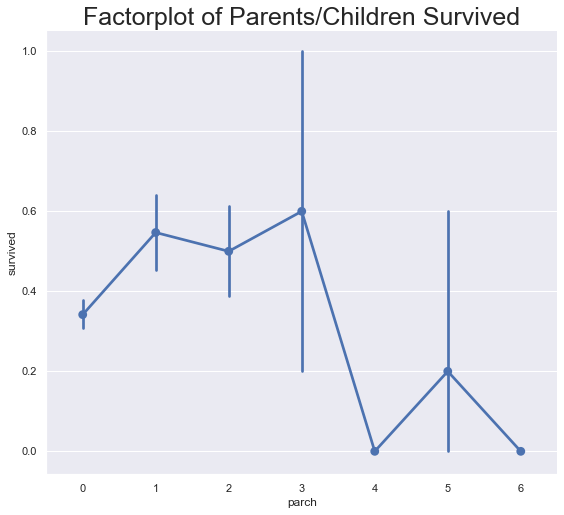

In [287]:
# Factor plot
sns.factorplot(x = 'parch', y = 'survived', data = train, kind = 'point', size= 8)
plt.title('Factorplot of Parents/Children Survived', fontsize = 25)
plt.subplots_adjust(top = 0.85)

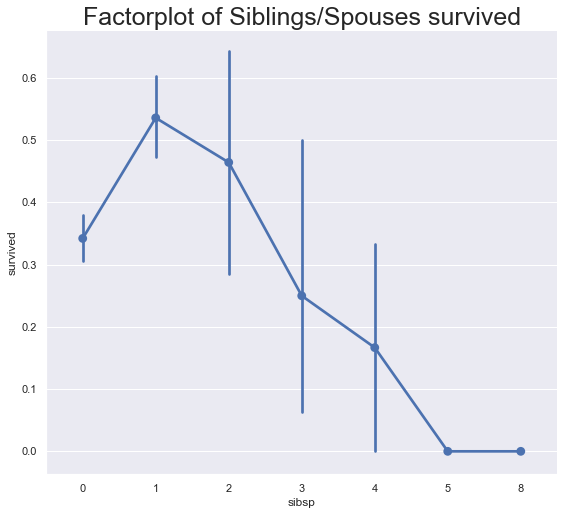

In [288]:
sns.factorplot(x = 'sibsp', y = 'survived', data = train, kind = 'point', size = 8)
plt.title('Factorplot of Siblings/Spouses survived', fontsize = 25)
plt.subplots_adjust(top = 0.85)

We can see for family sizes that passengers who traveled in big groups survived less

## Statistical Overview

In [289]:
# replace sex with 0 for female and 1 for male
train['sex'] = train.sex.apply(lambda x: 0 if x == 'female' else 1)
test['sex'] = test.sex.apply(lambda x: 0 if x == 'female' else 1)

In [290]:
train.describe()

,passengerid,pclass,sex,age,sibsp,parch,fare,survived
count,888.000000,888.000000,888.000000,711.000000,888.000000,888.000000,888.000000,888.000000
mean,445.618243,2.313063,0.647523,29.675345,0.524775,0.381757,30.582164,0.381757
std,257.405474,0.834007,0.478011,14.552495,1.104186,0.806949,41.176366,0.486091
min,1.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,222.750000,2.000000,0.000000,20.000000,0.000000,0.000000,7.895800,0.000000
50%,445.500000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,667.250000,3.000000,1.000000,38.000000,1.000000,0.000000,30.771850,1.000000
max,891.000000,3.000000,1.000000,80.000000,8.000000,6.000000,263.000000,1.000000


In [291]:
train.describe(include = ['O'])

,name,ticket,cabin,embarked
count,888,888,888,888
unique,888,680,8,3
top,"Goodwin, Miss. Lillian Amy",CA. 2343,G,S
freq,1,7,464,644


In [292]:
train.groupby('survived').mean().reset_index()

,survived,passengerid,pclass,sex,age,sibsp,parch,fare
0,0,447.016393,2.531876,0.852459,30.626179,0.553734,0.329690,22.117887
1,1,443.353982,1.958702,0.315634,28.270627,0.477876,0.466077,44.289799


This somewhat explains how people who survived differ from people who didn't on average

In [293]:
train.groupby('sex').mean().reset_index()

,sex,passengerid,pclass,age,sibsp,parch,fare,survived
0,0,431.578275,2.162939,27.888462,0.696486,0.651757,42.985091,0.741214
1,1,453.260870,2.394783,30.705477,0.431304,0.234783,23.830658,0.186087


There is a huge difference between survival rate between male and female (0 for female, 1 for male)

In [294]:
train.groupby('pclass').mean().reset_index()

,pclass,passengerid,sex,age,sibsp,parch,fare,survived
0,1,460.225352,0.563380,38.280984,0.422535,0.356808,78.124061,0.624413
1,2,445.956522,0.586957,29.877630,0.402174,0.380435,20.662183,0.472826
2,3,439.154786,0.706721,25.140620,0.615071,0.393075,13.675550,0.242363


Higher class people survived more in percentage

### Correlation Matrix and Heatmap

In [295]:
pd.DataFrame(abs(train.corr()['survived']).sort_values(ascending = False))

,survived
survived,1.000000
sex,0.545899
pclass,0.334068
fare,0.261742
parch,0.082157
age,0.079472
sibsp,0.033395
passengerid,0.006916


Sex has the highest correlation, then pclass, etc.

In [296]:
corr = train.corr() ** 2
corr.survived.sort_values(ascending = False)

survived       1.000000
sex            0.298006
pclass         0.111601
fare           0.068509
parch          0.006750
age            0.006316
sibsp          0.001115
passengerid    0.000048
Name: survived, dtype: float64

Text(0.5, 1.03, 'Correlations Among Features')

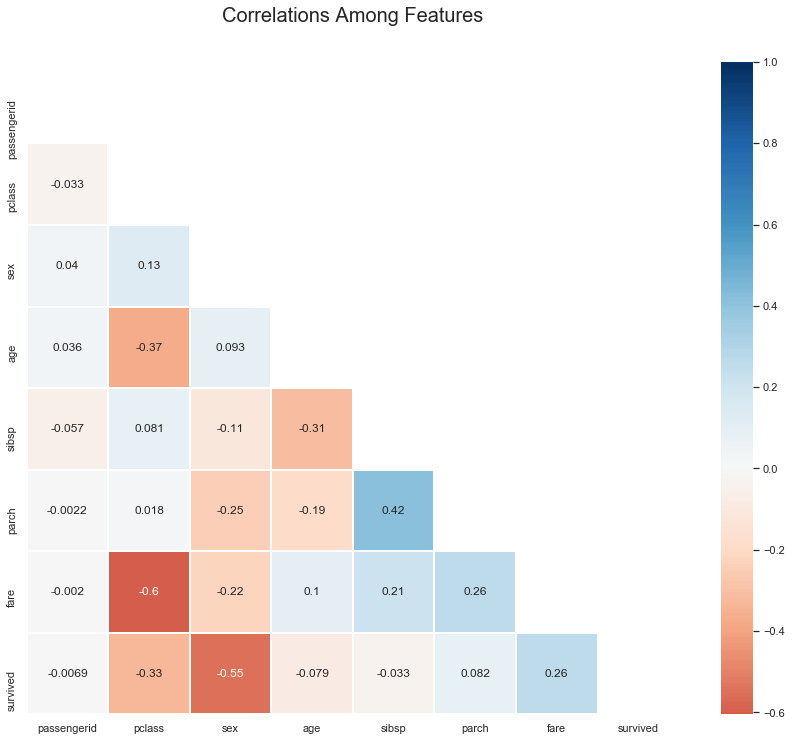

In [297]:
# heatmap to see the correlation between features
# generate a mask for upper triangle
mask = np.zeros_like(train.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set_style('whitegrid')
plt.subplots(figsize = (15, 12))
sns.heatmap(train.corr(), 
            annot = True, 
            mask = mask, 
            cmap = 'RdBu', # in order to reverse the order, use RdBu_r
            linewidths = .9,
            linecolor = 'white',
            fmt = '.2g',
            center = 0,
            square = True)
plt.title('Correlations Among Features', y = 1.03, fontsize = 20, pad = 40)

The most significant correlation were 
1. fare and pclass: -0.6
2. sex and survived: -0.55

First of all, sex and survived show as negative correlation because female (0) survived more than male (1)

Between fare and pclass, it seems obvious that these two have a strong correlation since their fares would be related to how much they paid for those tickets. However, if we look at each feature in relation to survived:
1. fare and survived: 0.26
2. pclass and survived: -0.33

Both variables seems to be fairly related to survival rate, which tells us that how much a passenger paid for (and thus their passenger class) seems to be correlated to survival

However, even if we have correlations, we must check for their statistical significance before we can say that they truly have a relationship

#### Hypothesis Testing for Correlation

Hypothesis: Is there a significant difference between mean survival of men and women?
 * Ho: difference = 0

However, since we assume that mean survival of women is higher than men, we can use a one-tailed test for alternative
 * Ha: mean survival of women - mean survival of men > 0

Since we have only a sample of passengers of the Titanic, we must approach this problem using sample sets:

Kaggle: The idea of using sample set is that; if we take <b>multiple samples of the same population and take the mean of them and put them in a distribution; eventually the distribution start to look more like a normal distribution</b>. The more samples we take and the more sample means will be added and, the closer the normal distribution will reach towards population mean. This is where <b>Central limit theory</b> comes from. We will go more in depth of this topic later on.

Thus, we will take 50 random samples each of male and female and take a mean of means of the samples

In [298]:
import random

# separate out male and female
male = train[train.sex == 1]
female = train[train.sex == 0]

# empty list for storing means of samples
male_sample = []
female_sample = []

# append mean of each sample 50 times
for i in range(50):
    male_sample.append(np.mean(random.sample(list(male['survived']), 50,)))
    female_sample.append(np.mean(random.sample(list(female['survived']), 50,)))

# print out the mean of means
print(f'Male mean sample mean: {round(np.mean(male_sample), 2)}')
# f is the same as % or .format for strings: you can put code/variable inside the string to have it print out its value
print(f'Female mean sample mean: {round(np.mean(female_sample), 2)}')
print(f'Difference between female and male mean sample mean: {round(np.mean(female_sample) - np.mean(male_sample), 2)}')


Male mean sample mean: 0.19
Female mean sample mean: 0.74
Difference between female and male mean sample mean: 0.55


Now that we have the difference of mean of sample means, we will test how significant this difference of 0.53 is, keeping in mind that:
1. we used 50 samples with 50 male and 50 female each
2. the samples are from a broader population (the train set)

In order to test for how significant the difference is, we can use t-test to evaluate

In [299]:
from scipy import stats

In [300]:
stats.ttest_ind(female_sample, male_sample)

Ttest_indResult(statistic=45.729739708640864, pvalue=6.47088271066435e-68)

## Feature Engineering

In [301]:
# dataset with train and test combined
combine = [train, test]

### Title

In [302]:
# extract titles from each name
for dataset in combine:
    dataset['title'] = dataset.name.str.extract(' ([A-Za-z]+)\.', expand = False)

pd.crosstab(train['title'], train['sex'])

sex,0,1
title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [303]:
# convert titles that are not Mr, Miss, Mrs, and Master to Rare
def convert_title(title):
    result = ''
    if title in ['Capt', 'Col', 'Countess', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Rev', 'Sir', 'Dona']:
        result = 'Rare'
    elif title in ['Ms', 'Mlle']:
        result = 'Miss'
    elif title == 'Mme':
        result = 'Mrs'
    else:
        result = title
    return result

for dataset in combine:
    dataset['title'] = dataset['title'].map(convert_title)
    print(dataset.title.unique())


['Mr' 'Mrs' 'Miss' 'Master' 'Rare']
['Mr' 'Mrs' 'Miss' 'Master' 'Rare']


### Family Size

In [304]:
for dataset in combine:
    dataset['familysize'] = dataset['sibsp'] + dataset['parch'] + 1

def family_bin(size):
    a = ''
    if size <= 1:
        a = 'alone'
    elif size <= 4:
        a = 'small'
    else:
        a = 'large'
    return a

for dataset in combine:
    dataset['family_group'] = dataset['familysize'].map(family_bin)
    print(dataset['family_group'].unique())

['small' 'alone' 'large']
['alone' 'small' 'large']


### Is Alone

In [305]:
for dataset in combine:
    dataset['isalone'] = 0
    dataset.loc[dataset['familysize'] == 1, 'isalone'] = 1

In [306]:
train

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived,title,familysize,family_group,isalone
0,1,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,G,S,0,Mr,2,small,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C,C,1,Mrs,2,small,0
2,3,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,G,S,1,Miss,1,alone,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C,S,1,Mrs,2,small,0
4,5,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,G,S,0,Mr,1,alone,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,G,S,0,Rare,1,alone,1
887,888,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,30.0000,B,S,1,Miss,1,alone,1
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,NaN,1,2,W./C. 6607,23.4500,F,S,0,Miss,4,small,0
889,890,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,30.0000,C,C,1,Mr,1,alone,1


### Ticket (Remove)

In [307]:
for dataset in combine:
    dataset.drop('ticket', axis = 1, inplace = True)

In [308]:
train

,passengerid,pclass,name,sex,age,sibsp,parch,fare,cabin,embarked,survived,title,familysize,family_group,isalone
0,1,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,G,S,0,Mr,2,small,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,C,C,1,Mrs,2,small,0
2,3,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,G,S,1,Miss,1,alone,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,C,S,1,Mrs,2,small,0
4,5,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,G,S,0,Mr,1,alone,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",1,27.0,0,0,13.0000,G,S,0,Rare,1,alone,1
887,888,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,30.0000,B,S,1,Miss,1,alone,1
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,NaN,1,2,23.4500,F,S,0,Miss,4,small,0
889,890,1,"Behr, Mr. Karl Howell",1,26.0,0,0,30.0000,C,C,1,Mr,1,alone,1


### Calculated Fare

Since Fare seems to keep a total price of tickets for all family members, we can divide up by family size to get price for individual

In [309]:
for dataset in combine:
    dataset['calculated_fare'] = dataset.fare/dataset.familysize

In [310]:
train

,passengerid,pclass,name,sex,age,sibsp,parch,fare,cabin,embarked,survived,title,familysize,family_group,isalone,calculated_fare
0,1,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,G,S,0,Mr,2,small,0,3.62500
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,C,C,1,Mrs,2,small,0,35.64165
2,3,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,G,S,1,Miss,1,alone,1,7.92500
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,C,S,1,Mrs,2,small,0,26.55000
4,5,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,G,S,0,Mr,1,alone,1,8.05000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",1,27.0,0,0,13.0000,G,S,0,Rare,1,alone,1,13.00000
887,888,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,30.0000,B,S,1,Miss,1,alone,1,30.00000
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,NaN,1,2,23.4500,F,S,0,Miss,4,small,0,5.86250
889,890,1,"Behr, Mr. Karl Howell",1,26.0,0,0,30.0000,C,C,1,Mr,1,alone,1,30.00000


### Fare Group

In [311]:
train['fare_group'] = pd.cut(train['calculated_fare'], bins = 4)
def fare_group(fare):
    a = ''
    if fare <= 4:
        a = 'Very_low'
    elif fare <= 10:
        a = 'low'
    elif fare <= 20:
        a = 'mid'
    elif fare <= 45:
        a = 'high'
    else:
        a = 'very_high'
    return a

for dataset in combine:
    dataset['fare_group'] = dataset['calculated_fare'].map(fare_group)

In [312]:
train

,passengerid,pclass,name,sex,age,sibsp,parch,fare,cabin,embarked,survived,title,familysize,family_group,isalone,calculated_fare,fare_group
0,1,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,G,S,0,Mr,2,small,0,3.62500,Very_low
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,C,C,1,Mrs,2,small,0,35.64165,high
2,3,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,G,S,1,Miss,1,alone,1,7.92500,low
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,C,S,1,Mrs,2,small,0,26.55000,high
4,5,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,G,S,0,Mr,1,alone,1,8.05000,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",1,27.0,0,0,13.0000,G,S,0,Rare,1,alone,1,13.00000,mid
887,888,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,30.0000,B,S,1,Miss,1,alone,1,30.00000,high
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,NaN,1,2,23.4500,F,S,0,Miss,4,small,0,5.86250,low
889,890,1,"Behr, Mr. Karl Howell",1,26.0,0,0,30.0000,C,C,1,Mr,1,alone,1,30.00000,high


### PassengerId (Remove)

In [313]:
for dataset in combine:
    dataset.drop('passengerid', axis = 1, inplace = True)

In [314]:
train

,pclass,name,sex,age,sibsp,parch,fare,cabin,embarked,survived,title,familysize,family_group,isalone,calculated_fare,fare_group
0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,G,S,0,Mr,2,small,0,3.62500,Very_low
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,C,C,1,Mrs,2,small,0,35.64165,high
2,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,G,S,1,Miss,1,alone,1,7.92500,low
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,C,S,1,Mrs,2,small,0,26.55000,high
4,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,G,S,0,Mr,1,alone,1,8.05000,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,"Montvila, Rev. Juozas",1,27.0,0,0,13.0000,G,S,0,Rare,1,alone,1,13.00000,mid
887,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,30.0000,B,S,1,Miss,1,alone,1,30.00000,high
888,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,NaN,1,2,23.4500,F,S,0,Miss,4,small,0,5.86250,low
889,1,"Behr, Mr. Karl Howell",1,26.0,0,0,30.0000,C,C,1,Mr,1,alone,1,30.00000,high


### Dummy Variables
Kaggle: Dummy variable is an <b>important prepocessing machine learning step</b>. Often times Categorical variables are an important features, which can be the difference between a good model and a great model. While working with a dataset, having meaningful value for example, "male" or "female" instead of 0's and 1's is more intuitive for us. However, <b>machines do not understand the value of categorical values</b>, for example, in this dataset we have gender male or female, <b>algorithms do not accept categorical variables as input</b>.

In [315]:
train = pd.get_dummies(train, columns = ['title', 'pclass', 'cabin', 'embarked',
                                           'family_group', 'fare_group'], drop_first = False)
test = pd.get_dummies(test, columns = ['title', 'pclass', 'cabin', 'embarked',
                                           'family_group', 'fare_group'], drop_first = False)

In [316]:
train.head()

,name,sex,age,sibsp,parch,fare,survived,familysize,isalone,calculated_fare,...,embarked_Q,embarked_S,family_group_alone,family_group_large,family_group_small,fare_group_Very_low,fare_group_high,fare_group_low,fare_group_mid,fare_group_very_high
0,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,0,2,0,3.62500,...,0,1,0,0,1,1,0,0,0,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,1,2,0,35.64165,...,0,0,0,0,1,0,1,0,0,0
2,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,1,1,1,7.92500,...,0,1,1,0,0,0,0,1,0,0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,1,2,0,26.55000,...,0,1,0,0,1,0,1,0,0,0
4,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,0,1,1,8.05000,...,0,1,1,0,0,0,0,1,0,0


In [317]:
test.head()

,name,sex,age,sibsp,parch,fare,familysize,isalone,calculated_fare,title_Master,...,embarked_Q,embarked_S,family_group_alone,family_group_large,family_group_small,fare_group_Very_low,fare_group_high,fare_group_low,fare_group_mid,fare_group_very_high
0,"Kelly, Mr. James",1,34.5,0,0,7.8292,1,1,7.829200,0,...,1,0,1,0,0,0,0,1,0,0
1,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,7.0000,2,0,3.500000,0,...,0,1,0,0,1,1,0,0,0,0
2,"Myles, Mr. Thomas Francis",1,62.0,0,0,9.6875,1,1,9.687500,0,...,1,0,1,0,0,0,0,1,0,0
3,"Wirz, Mr. Albert",1,27.0,0,0,8.6625,1,1,8.662500,0,...,0,1,1,0,0,0,0,1,0,0
4,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,12.2875,3,0,4.095833,0,...,0,1,0,0,1,0,0,1,0,0


## Filling in NA Values in Age using Random Forest Regressor

In [318]:
# setting up dataset for prediction
train = pd.concat([train[['survived', 'age', 'sex', 'sibsp', 'parch']], train.loc[:, 'isalone':]], axis = 1)
test = pd.concat([test[['age', 'sex']], test.loc[:, 'sibsp':]], axis = 1)

In [320]:
# import random forest
from sklearn.ensemble import RandomForestRegressor

# function for filling in missing values
def fill_age(df):
    # extract all columns except survived
    age_df = df.loc[:, 'age':]
    
    temp_train = age_df.loc[age_df.age.notnull()]
    temp_test = age_df.loc[age_df.age.isnull()]
    
    y = temp_train.age.values
    x = temp_train.loc[:, 'sex':].values
    
    rfr = RandomForestRegressor(n_estimators = 1500, n_jobs = -1)
    rfr.fit(x, y)
    
    pred_age = rfr.predict(temp_test.loc[:, 'sex':])
    
    df.loc[df.age.isnull(), 'age'] = pred_age
    
    return df

fill_age(train)
fill_age(test)

,age,sex,sibsp,parch,fare,familysize,isalone,calculated_fare,title_Master,title_Miss,...,embarked_Q,embarked_S,family_group_alone,family_group_large,family_group_small,fare_group_Very_low,fare_group_high,fare_group_low,fare_group_mid,fare_group_very_high
0,34.500000,1,0,0,7.8292,1,1,7.829200,0,0,...,1,0,1,0,0,0,0,1,0,0
1,47.000000,0,1,0,7.0000,2,0,3.500000,0,0,...,0,1,0,0,1,1,0,0,0,0
2,62.000000,1,0,0,9.6875,1,1,9.687500,0,0,...,1,0,1,0,0,0,0,1,0,0
3,27.000000,1,0,0,8.6625,1,1,8.662500,0,0,...,0,1,1,0,0,0,0,1,0,0
4,22.000000,0,1,1,12.2875,3,0,4.095833,0,0,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,26.739256,1,0,0,8.0500,1,1,8.050000,0,0,...,0,1,1,0,0,0,0,1,0,0
414,39.000000,0,0,0,108.9000,1,1,108.900000,0,0,...,0,0,1,0,0,0,0,0,0,1
415,38.500000,1,0,0,7.2500,1,1,7.250000,0,0,...,0,1,1,0,0,0,0,1,0,0
416,26.739256,1,0,0,8.0500,1,1,8.050000,0,0,...,0,1,1,0,0,0,0,1,0,0


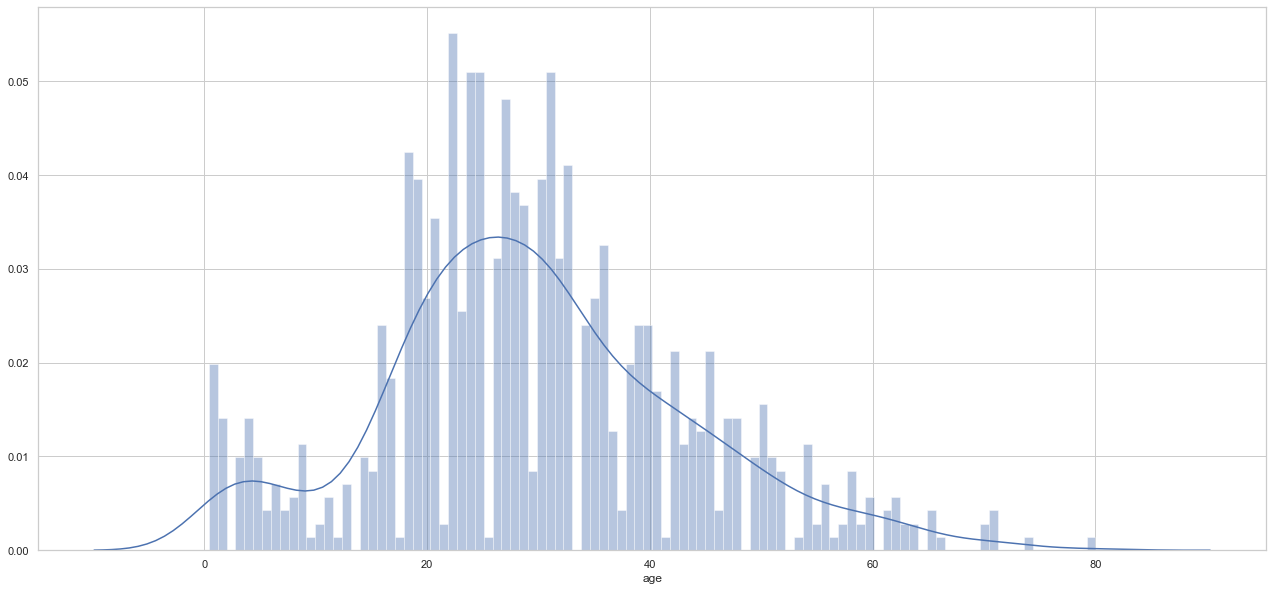

In [321]:
# histogram of age
plt.subplots(figsize = (22, 10),)
sns.distplot(train.age, bins = 100, kde = True, rug = False, norm_hist = False)

In [330]:
# define age groups
def age_group(age):
    a = ''
    if age <= 1:
        a = 'infant'
    elif age <= 4:
        a = 'toddler'
    elif age <= 13:
        a = 'child'
    elif age <= 18:
        a = 'teenager'
    elif age <= 35:
        a = 'Young_Adult'
    elif age <= 45:
        a = 'adult'
    elif age <= 55:
        a = 'middle_aged'
    elif age <= 65:
        a = 'senior_citizen'
    else:
        a = 'old'
    return a

# apply function
train['age_group'] = train['age'].map(age_group)
test['age_group'] = test['age'].map(age_group)
print(train['age_group'].value_counts())
print(test['age_group'].value_counts())

# dummy variables
train = pd.get_dummies(train, columns = ['age_group'], drop_first = False)
test = pd.get_dummies(test, columns = ['age_group'], drop_first = False)

Young_Adult       473
adult             151
teenager           70
middle_aged        68
child              43
senior_citizen     34
toddler            27
infant             14
old                 8
Name: age_group, dtype: int64
Young_Adult       242
adult              60
middle_aged        37
teenager           27
child              22
senior_citizen     17
infant              8
toddler             3
old                 2
Name: age_group, dtype: int64


In [332]:
train.head()

,survived,age,sex,sibsp,parch,isalone,calculated_fare,title_Master,title_Miss,title_Mr,...,age_group_toddler,age_group_Young_Adult,age_group_adult,age_group_child,age_group_infant,age_group_middle_aged,age_group_old,age_group_senior_citizen,age_group_teenager,age_group_toddler
0,0,22.0,1,1,0,0,3.62500,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1,1,38.0,0,1,0,0,35.64165,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,26.0,0,0,0,1,7.92500,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,1,35.0,0,1,0,0,26.55000,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,35.0,1,0,0,1,8.05000,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [333]:
test.head()

,age,sex,sibsp,parch,fare,familysize,isalone,calculated_fare,title_Master,title_Miss,...,age_group_toddler,age_group_Young_Adult,age_group_adult,age_group_child,age_group_infant,age_group_middle_aged,age_group_old,age_group_senior_citizen,age_group_teenager,age_group_toddler
0,34.5,1,0,0,7.8292,1,1,7.829200,0,0,...,0,1,0,0,0,0,0,0,0,0
1,47.0,0,1,0,7.0000,2,0,3.500000,0,0,...,0,0,0,0,0,1,0,0,0,0
2,62.0,1,0,0,9.6875,1,1,9.687500,0,0,...,0,0,0,0,0,0,0,1,0,0
3,27.0,1,0,0,8.6625,1,1,8.662500,0,0,...,0,1,0,0,0,0,0,0,0,0
4,22.0,0,1,1,12.2875,3,0,4.095833,0,0,...,0,1,0,0,0,0,0,0,0,0


## Pre-Modeling Tasks

### Separating Independent and Dependent Variables

In [334]:
x = train.drop(['survived'], axis = 1)
y = train['survived']